Imports

In [1]:
import sys 
sys.path.insert(1, "../utils")

In [59]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from knn import  KNN
from random_forest import RandomForestClassifier
from decisionTreeClassifier import MyDecisionTreeClassifier
from sklearn.model_selection import train_test_split
import utils
from joblib import Parallel, delayed
import random
import math
import collections
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# load dataset

In [3]:
from utils import load_data
dataset = load_data('../Data/Dataset1_cleaned.csv')

In [4]:
X = dataset.drop('Fertility', axis=1)
Y = dataset['Fertility']

# 1- Séparer le dataset

In [5]:
# traiter chaque classe séparément
classe_0 = dataset[dataset['Fertility'] == 0]
print("Longueur de la classe 0 : ", len(classe_0))
classe_1 = dataset[dataset['Fertility'] == 1]
print("Longueur de la classe 1 : ", len(classe_1))
classe_2 = dataset[dataset['Fertility'] == 2]
print("Longueur de la classe 2 : ", len(classe_2))
# séparer les données en données d'apprentissage et de test
train_classe_0, test_classe_0 = train_test_split(classe_0, test_size=0.2)
train_classe_1, test_classe_1 = train_test_split(classe_1, test_size=0.2)
train_classe_2, test_classe_2 = train_test_split(classe_2, test_size=0.2)
# concaténer les données d'apprentissage et de test
train_data = pd.concat([train_classe_0, train_classe_1, train_classe_2], axis=0)
test_data = pd.concat([test_classe_0, test_classe_1, test_classe_2], axis=0)


Longueur de la classe 0 :  401
Longueur de la classe 1 :  441
Longueur de la classe 2 :  40


In [6]:
train_data

,N,P,K,pH,OC,S,Zn,Fe,Cu,Mn,B,Fertility
123,0.246334,0.315018,0.406065,0.508929,0.687500,0.571731,0.656934,0.234918,0.459330,0.365714,0.792453,0
54,0.000000,0.175824,0.812870,0.401786,0.750000,0.857244,0.145985,0.043947,0.397129,0.143896,1.000000,0
574,0.651026,0.234432,0.718195,0.598214,0.453125,0.656327,0.306569,0.239712,0.851675,0.568312,0.245283,0
128,0.630499,0.256410,0.389793,0.508929,0.226562,0.337681,0.306569,0.197363,0.559809,0.992208,0.462264,0
395,0.448680,0.219780,0.406065,0.294643,0.226562,0.316532,0.452555,0.508989,0.444976,0.540779,0.415094,0
...,...,...,...,...,...,...,...,...,...,...,...,...
498,0.815249,1.000000,0.406065,0.669643,0.531250,0.231230,0.598540,0.488214,0.444976,0.385974,0.245283,2
864,0.853372,0.717949,1.000000,0.151786,0.609375,0.401128,0.992701,0.379545,0.473684,0.619221,0.500000,2
496,0.853372,1.000000,0.312870,0.464286,0.078125,0.295382,0.700730,0.648022,0.555024,0.619221,0.415094,2
693,0.961877,1.000000,0.546598,1.000000,0.320312,0.145224,0.277372,0.131043,0.004785,0.007792,0.301887,2


In [7]:
test_data

,N,P,K,pH,OC,S,Zn,Fe,Cu,Mn,B,Fertility
412,0.630499,0.285714,0.468195,0.187500,0.382812,0.252379,0.467153,0.752697,0.258373,0.437922,0.443396,0
160,0.281525,0.351648,0.437130,0.598214,0.171875,0.483609,0.379562,0.298042,0.244019,0.463896,0.056604,0
370,0.501466,0.300366,0.687130,0.151786,0.148437,0.358830,0.759124,0.426688,0.473684,0.620779,0.216981,0
280,0.557185,0.300366,0.453402,0.616071,0.265625,0.391963,0.423358,0.208550,0.263158,0.436883,0.037736,0
698,0.521994,0.351648,0.530325,1.000000,0.281250,0.406063,0.408759,0.025569,0.157895,0.190130,0.754717,0
...,...,...,...,...,...,...,...,...,...,...,...,...
497,0.906158,1.000000,0.827663,0.580357,0.757812,0.422982,0.437956,0.346784,0.354067,0.322597,0.141509,2
717,0.982405,0.608059,0.687130,0.776786,0.343750,0.222771,0.437956,0.053536,0.105263,0.052987,0.745283,2
845,0.815249,0.798535,0.343935,0.401786,0.453125,0.486429,0.452555,0.415501,0.382775,0.464416,0.537736,2
865,0.906158,0.835165,0.593935,0.794643,0.226562,0.316532,0.423358,0.423492,0.698565,0.495584,0.198113,2


# 2- Algorithmes supervisée

<h2> KNN

In [8]:
X_train = train_data.drop('Fertility', axis=1)
y_train = train_data['Fertility']
X_test = test_data.drop('Fertility', axis=1)
y_test = test_data['Fertility']
k =  3
knn_classifier = KNN(k=k)
# Appliquer le modèle sur les données d'apprentissage
knn_classifier.fit(X_train, y_train)
# Prédire les classes des données de test
y_pred = knn_classifier.predict(X_test)
print("Predicted labels:", y_pred)


Predicted labels: [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 2 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]


Confusion matrix

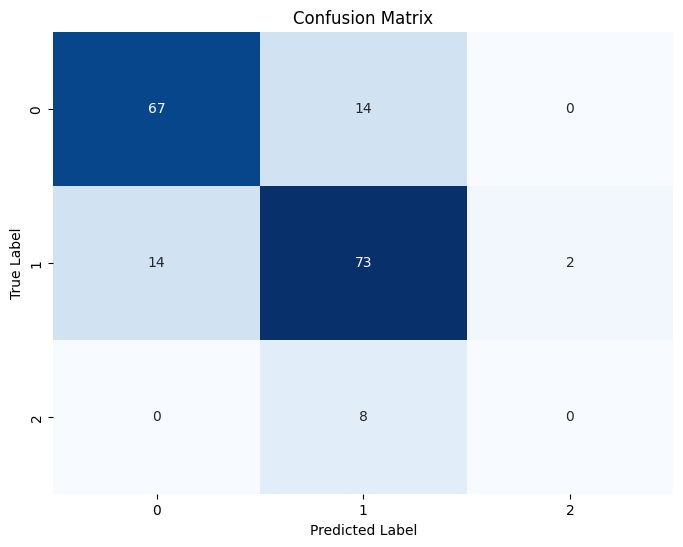

In [9]:
from importlib import reload
reload(utils)
cm_knn = utils.confusion_matrix(y_test, y_pred)
utils.plot_confusion_matrix(cm_knn)

<h3> Les differantes metriques

In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Metrics for each class

In [11]:
print("class 0: \n")
accuracy0_knn = utils.class_accuracy(y_test, y_pred, 0)
print("Accuracy: ", accuracy0_knn)
precision0_knn = utils.precision_class(cm_knn, 0)
print("Precision: ", precision0_knn)
recall0_knn = utils.recall_class(cm_knn, 0)
print("Recall: ", recall0_knn)
specifity0_knn = utils.specificity_class(cm_knn, 0)
print("Specificity: ", specifity0_knn)
fscore0_knn = utils.f_score_class(cm_knn, 0)
print("F score: ", fscore0_knn)
print("\n")
print("class 1: \n")
accuracy1_knn = utils.class_accuracy(y_test, y_pred, 1)
print("Accuracy: ", accuracy1_knn)
precision1_knn = utils.precision_class(cm_knn, 1)
print("Precision: ", precision1_knn)
recall1_knn = utils.recall_class(cm_knn, 1)
print("Recall: ", recall1_knn)
specifity1_knn = utils.specificity_class(cm_knn, 1)
print("Specificity: ", specifity1_knn)
fscore1_knn = utils.f_score_class(cm_knn, 1)
print("F score: ", fscore1_knn)
print("\n")
print("class 2: \n")
accuracy2_knn = utils.class_accuracy(y_test, y_pred, 2)
print("Accuracy: ", accuracy2_knn)
precision2_knn = utils.precision_class(cm_knn, 2)
print("Precision: ", precision2_knn)
recall2_knn = utils.recall_class(cm_knn, 2)
print("Recall: ", recall2_knn)
specifity2_knn = utils.specificity_class(cm_knn, 2)
print("Specificity: ", specifity2_knn)
fscore2_knn = utils.f_score_class(cm_knn, 2)
print("F score: ", fscore2_knn)


class 0: 

Accuracy:  0.8271604938271605
Precision:  0.8271604938271605
Recall:  0.8271604938271605
Specificity:  0.8556701030927835
F score:  0.8271604938271605


class 1: 

Accuracy:  0.8202247191011236
Precision:  0.7684210526315789
Recall:  0.8202247191011236
Specificity:  0.8072289156626506
F score:  0.7934782608695652


class 2: 

Accuracy:  0.0
Precision:  0.0
Recall:  0.0
Specificity:  0.9545454545454546
F score:  0


Metrics for the whole classifier

In [12]:
acc_knn = utils.accuracy(y_test, y_pred)
print(f'Accuracy: {acc_knn:.4f}')
pre_knn = utils.precision(cm_knn)
print(f'Precision: {pre_knn:.4f}')
rec_knn = utils.recall(cm_knn)
print(f'Recall: {rec_knn:.4f}')
spec_knn = utils.specificity(cm_knn)
print(f'Specifity: {spec_knn:.4f}')
f1_knn = utils.f_score(cm_knn)
print(f'F-score: {f1_knn:.4f}')


Accuracy: 0.7865
Precision: 0.5319
Recall: 0.5491
Specifity: 0.8725
F-score: 0.5402


La courbe ROC

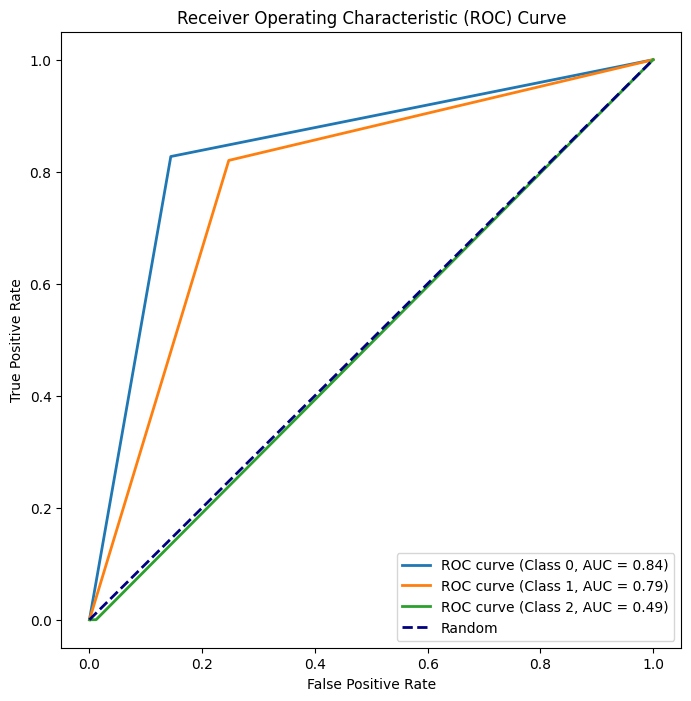

In [13]:


y_test_binary = label_binarize(y_test, classes=list(set(y_test)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(set(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], (y_pred == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(8, 8))
for i in range(len(set(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (Class {i}, AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


<h3> Tests sur K

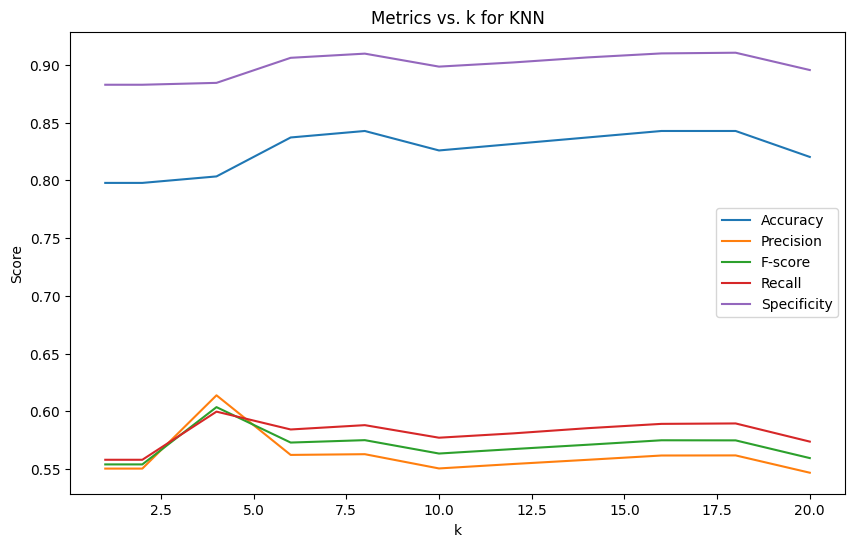

In [196]:
k_s = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
acc_scores = []
pre_scores = []
f_scores = []
rec_scores = []
spec_scores = []

for k in k_s:
    knn_classifier = KNN(k=k)
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(X_test)
    cm_knn = utils.confusion_matrix(y_test, y_pred)
    
    acc = utils.accuracy(y_test, y_pred)
    pre = utils.precision(cm_knn)
    f = utils.f_score(cm_knn)
    rec = utils.recall(cm_knn)
    spec = utils.specificity(cm_knn)

    
    acc_scores.append(acc)
    pre_scores.append(pre)
    f_scores.append(f)
    rec_scores.append(rec)
    spec_scores.append(spec)


# Plotting
plt.figure(figsize=(10, 6))

plt.plot(k_s, acc_scores, label='Accuracy')
plt.plot(k_s, pre_scores, label='Precision')
plt.plot(k_s, f_scores, label='F-score')
plt.plot(k_s, rec_scores, label='Recall')
plt.plot(k_s, spec_scores, label='Specificity')


plt.xlabel('k')
plt.ylabel('Score')
plt.title('Metrics vs. k for KNN')
plt.legend()
plt.show()


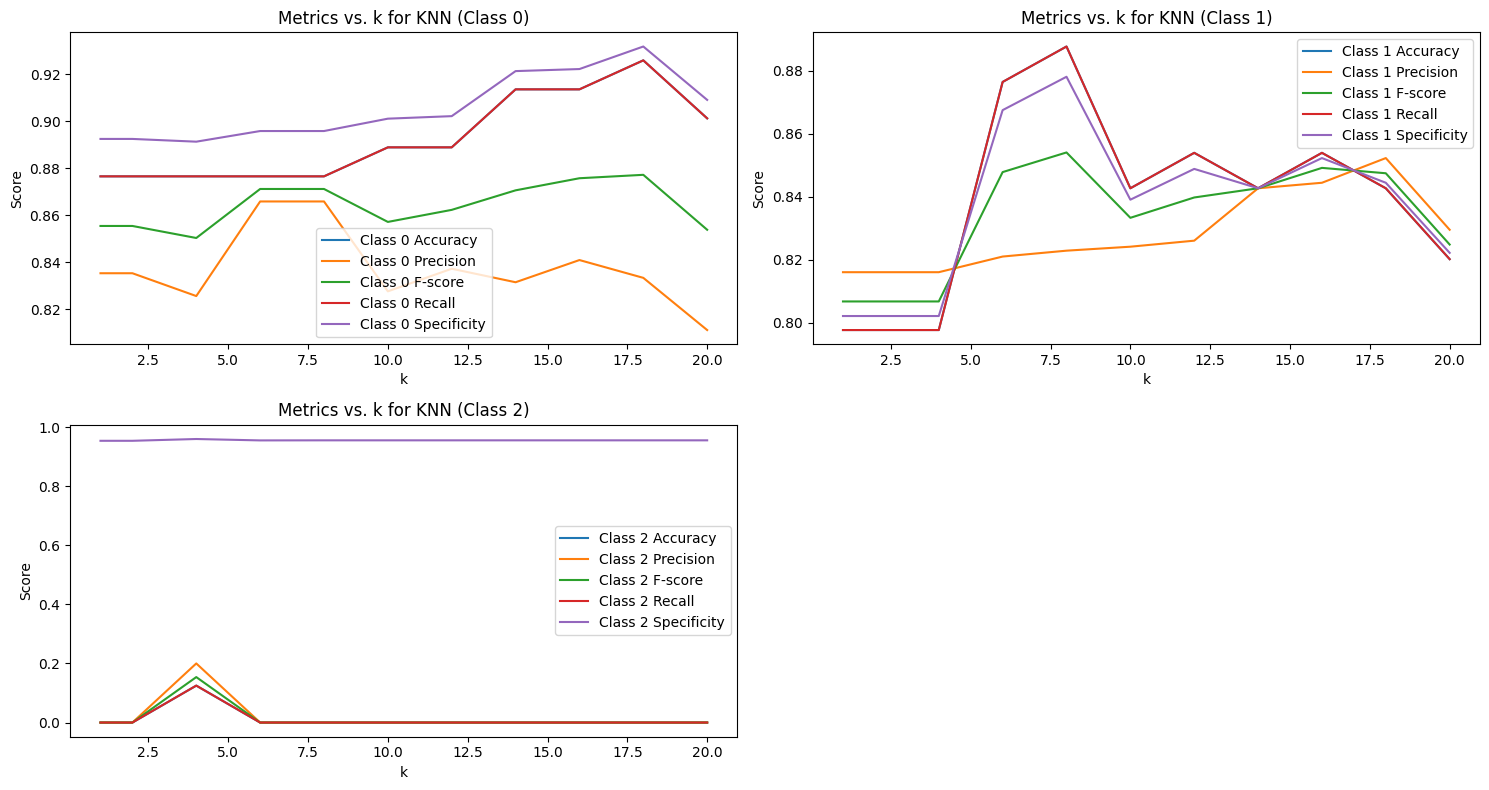

In [197]:
reload(utils)
X_test = test_data.drop('Fertility', axis=1)
y_test = test_data['Fertility']
X_train = train_data.drop('Fertility', axis=1)
y_train = train_data['Fertility']
k_s = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
num_classes = 3

acc_scores = {i: [] for i in range(num_classes)}
pre_scores = {i: [] for i in range(num_classes)}
f_scores = {i: [] for i in range(num_classes)}
rec_scores = {i: [] for i in range(num_classes)}
spec_scores = {i: [] for i in range(num_classes)}

for k in k_s:
    knn_classifier = KNN(k=k)
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(X_test)
    cm_knn = utils.confusion_matrix(y_test, y_pred)

    for class_label in range(num_classes):
        acc = utils.accuracy(y_test[y_test == class_label], y_pred[y_test == class_label])
        pre = utils.precision_class(cm_knn, class_label)
        f = utils.f_score_class(cm_knn, class_label)
        rec = utils.recall_class(cm_knn, class_label)
        spec = utils.specificity_class(cm_knn, class_label)

        acc_scores[class_label].append(acc)
        pre_scores[class_label].append(pre)
        f_scores[class_label].append(f)
        rec_scores[class_label].append(rec)
        spec_scores[class_label].append(spec)


# Plotting
plt.figure(figsize=(15, 8))

for class_label in range(num_classes):
    plt.subplot(2, 2, class_label + 1)
    plt.plot(k_s, acc_scores[class_label], label=f'Class {class_label} Accuracy')
    plt.plot(k_s, pre_scores[class_label], label=f'Class {class_label} Precision')
    plt.plot(k_s, f_scores[class_label], label=f'Class {class_label} F-score')
    plt.plot(k_s, rec_scores[class_label], label=f'Class {class_label} Recall')
    plt.plot(k_s, spec_scores[class_label], label=f'Class {class_label} Specificity')
    plt.xlabel('k')
    plt.ylabel('Score')
    plt.title(f'Metrics vs. k for KNN (Class {class_label})')
    plt.legend()

plt.tight_layout()
plt.show()


<h2> Random forest

In [25]:
clf = RandomForestClassifier(n_estimators=30,
                                 max_depth=7,
                                 )
feature_list = list(X.columns)
# Entraîner le classificateur
clf.fit(train_data[feature_list], train_data['Fertility'])

y_pred = clf.predict(test_data[feature_list])
y_test = test_data['Fertility']


{split_feature:N,split_value:0.6510263929618768,left_tree:{split_feature:P,split_value:0.5421245421245423,left_tree:{split_feature:Zn,split_value:0.1897810218978102,left_tree:{leaf_value:1},right_tree:{split_feature:N,split_value:0.5747800586510264,left_tree:{split_feature:Fe,split_value:0.03652183036921345,left_tree:{leaf_value:0},right_tree:{split_feature:P,split_value:0.4322344322344323,left_tree:{leaf_value:0},right_tree:{split_feature:OC,split_value:0.1484374999999999,left_tree:{leaf_value:1},right_tree:{leaf_value:0}}}},right_tree:{split_feature:S,split_value:0.6993302784631654,left_tree:{leaf_value:0},right_tree:{leaf_value:1}}}},right_tree:{split_feature:N,split_value:0.4486803519061583,left_tree:{leaf_value:0},right_tree:{split_feature:P,split_value:0.6886446886446889,left_tree:{split_feature:N,split_value:0.5953079178885631,left_tree:{leaf_value:0},right_tree:{leaf_value:1}},right_tree:{leaf_value:1}}}},right_tree:{split_feature:P,split_value:0.6373626373626374,left_tree:{spl

Confusion matrix

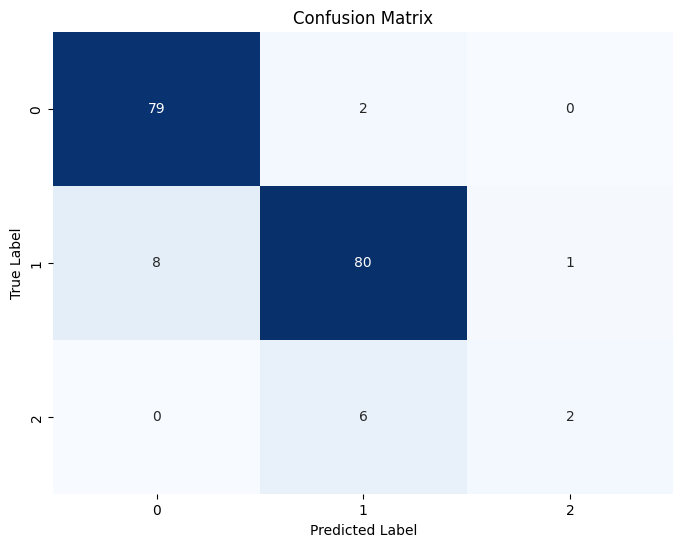

In [26]:
cm_rt = utils.confusion_matrix(y_test, y_pred)
utils.plot_confusion_matrix(cm_rt)

<h3> Les differantes metriques

Metrics for each class

In [27]:
print("class 0: \n")
accuracy0_rf = utils.class_accuracy(y_test, y_pred, 0)
print("Accuracy: ", accuracy0_rf)
precision0_rf = utils.precision_class(cm_rt, 0)
print("Precision: ", precision0_rf)
recall0_rf = utils.recall_class(cm_rt, 0)
print("Recall: ", recall0_rf)
specifity0_rf = utils.specificity_class(cm_rt, 0)
print("Specificity: ", specifity0_rf)
fscore0_rf = utils.f_score_class(cm_rt, 0)
print("F score: ", fscore0_rf)
print("\n")
print("class 1: \n")
accuracy1_rf = utils.class_accuracy(y_test, y_pred, 1)
print("Accuracy: ", accuracy1_rf)
precision1_rf = utils.precision_class(cm_rt, 1)
print("Precision: ", precision1_rf)
recall1_rf = utils.recall_class(cm_rt, 1)
print("Recall: ", recall1_rf)
specifity1_rf = utils.specificity_class(cm_rt, 1)
print("Specificity: ", specifity1_rf)
fscore1_rf = utils.f_score_class(cm_rt, 1)
print("F score: ", fscore1_rf)
print("\n")
print("class 2: \n")
accuracy2_rf = utils.class_accuracy(y_test, y_pred, 2)
print("Accuracy: ", accuracy2_rf)
precision2_rf = utils.precision_class(cm_rt, 2)
print("Precision: ", precision2_rf)
recall2_rf = utils.recall_class(cm_rt, 2)
print("Recall: ", recall2_rf)
specifity2_rf = utils.specificity_class(cm_rt, 2)
print("Specificity: ", specifity2_rf)
fscore2_rf = utils.f_score_class(cm_rt, 2)
print("F score: ", fscore2_rf)


class 0: 

Accuracy:  0.9753086419753086
Precision:  0.9080459770114943
Recall:  0.9753086419753086
Specificity:  0.978021978021978
F score:  0.9404761904761905


class 1: 

Accuracy:  0.898876404494382
Precision:  0.9090909090909091
Recall:  0.898876404494382
Specificity:  0.9
F score:  0.9039548022598869


class 2: 

Accuracy:  0.25
Precision:  0.6666666666666666
Recall:  0.25
Specificity:  0.9657142857142857
F score:  0.36363636363636365


Metrics for the whole classifier

In [28]:
acc_rf = utils.accuracy(y_test, y_pred)
print(f'Accuracy: {acc_rf:.4f}')
pre_rf = utils.precision(cm_rt)
print(f'Precision: {pre_rf:.4f}')
rec_rf = utils.recall(cm_rt)
print(f'Recall: {rec_rf:.4f}')
spec_rf = utils.specificity(cm_rt)
print(f'Specifity: {spec_rf:.4f}')
f1_rf = utils.f_score(cm_rt)
print(f'F-score: {f1_rf:.4f}')


Accuracy: 0.9045
Precision: 0.8279
Recall: 0.7081
Specifity: 0.9479
F-score: 0.7360


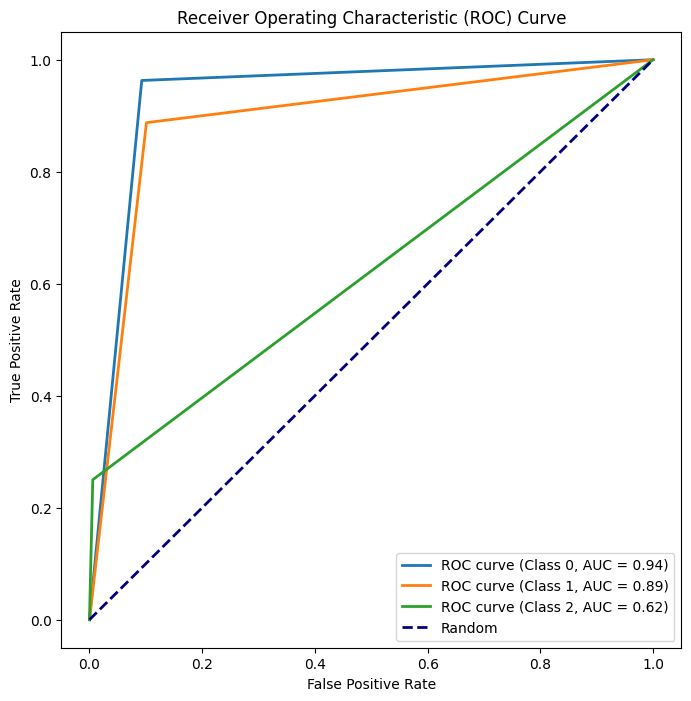

In [18]:
y_test_binary = label_binarize(y_test, classes=list(set(y_test)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(set(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], (y_pred == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(8, 8))
for i in range(len(set(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (Class {i}, AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


{split_feature:N,split_value:0.6304985337243402,left_tree:{split_feature:P,split_value:0.6080586080586081,left_tree:{leaf_value:0},right_tree:{leaf_value:1}},right_tree:{split_feature:P,split_value:0.95970695970696,left_tree:{leaf_value:1},right_tree:{leaf_value:1}}}
{split_feature:N,split_value:0.6304985337243402,left_tree:{split_feature:P,split_value:0.5421245421245423,left_tree:{leaf_value:0},right_tree:{leaf_value:1}},right_tree:{split_feature:P,split_value:0.7326007326007328,left_tree:{leaf_value:1},right_tree:{leaf_value:1}}}
{split_feature:N,split_value:0.6304985337243402,left_tree:{split_feature:P,split_value:0.6080586080586081,left_tree:{leaf_value:0},right_tree:{leaf_value:1}},right_tree:{split_feature:P,split_value:0.5421245421245423,left_tree:{leaf_value:1},right_tree:{leaf_value:1}}}
{split_feature:N,split_value:0.6304985337243402,left_tree:{split_feature:P,split_value:0.5421245421245423,left_tree:{leaf_value:0},right_tree:{leaf_value:1}},right_tree:{split_feature:P,split_

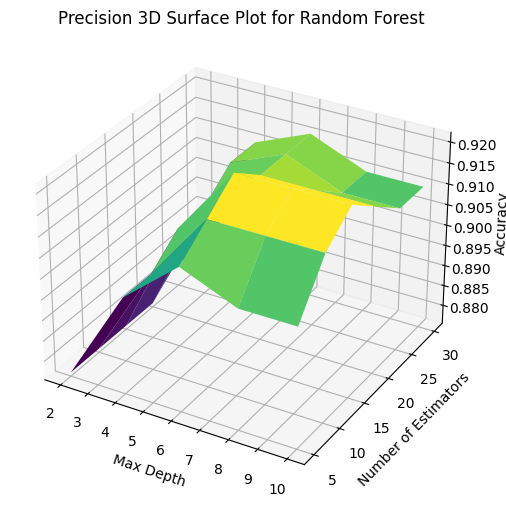

In [202]:
from mpl_toolkits.mplot3d import Axes3D

# Supposons que X_train, X_test, y_train, y_test soient vos données d'entraînement et de test
# Définissez la grille des hyperparamètres à tester
param_grid = {
    'n_estimators': [5,10,15, 20, 25,30],  # Ajoutez d'autres valeurs si nécessaire
    'max_depth': [2,4,6, 8, 10],  # Ajoutez d'autres valeurs si nécessaire
}

# Initialisez une figure pour le graphe 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Initialiser une matrice pour stocker les valeurs de précision
precision_matrix = np.zeros((len(param_grid['n_estimators']), len(param_grid['max_depth'])))

# Boucle sur les combinaisons d'hyperparamètres
for i, n_estimators in enumerate(param_grid['n_estimators']):
    for j, max_depth in enumerate(param_grid['max_depth']):
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=66)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy_score = utils.accuracy(y_test, y_pred)

        # Ajoutez la valeur à la matrice de précision
        precision_matrix[i, j] = accuracy_score

# Créez un graphe 3D à l'aide de plot_surface
X, Y = np.meshgrid(param_grid['max_depth'], param_grid['n_estimators'])
ax.plot_surface(X, Y, precision_matrix, cmap="viridis")

# Ajoutez des labels et un titre
ax.set_xlabel('Max Depth')
ax.set_ylabel('Number of Estimators')
ax.set_zlabel('Accuracy')
ax.set_title('Precision 3D Surface Plot for Random Forest')

# Affichez la figure
plt.show()


<h2> Decision Tree

In [19]:
X = dataset.drop('Fertility', axis=1)
feature_list = list(X.columns)
tree = MyDecisionTreeClassifier(min_samples_split=2, max_depth=3, min_samples_leaf=1)
tree.fit(train_data[feature_list], train_data['Fertility'])
# tree.print_tree()
# Make predictions
y_pred = tree.predict(test_data[feature_list])
y_test = test_data['Fertility']
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 2 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 0 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 1 1 0 2 2 2 1 2 2 1]


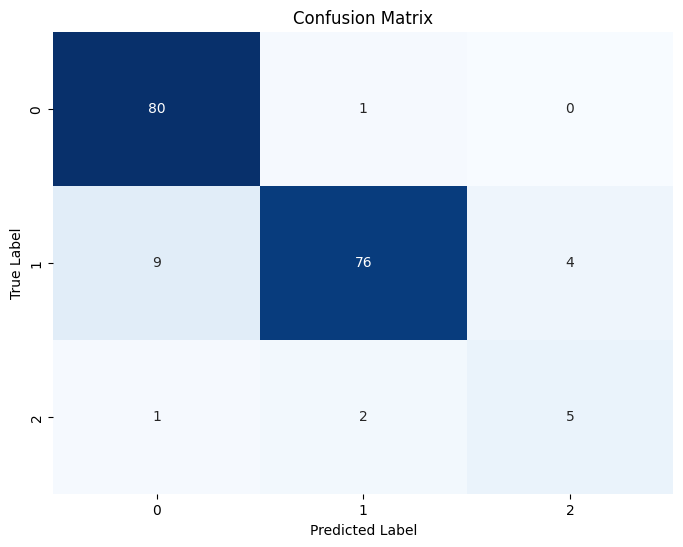

In [20]:
y_test = test_data['Fertility']
cm_dt = utils.confusion_matrix(y_test, y_pred)
utils.plot_confusion_matrix(cm_dt)

In [21]:
print("class 0: \n")
accuracy0_dt = utils.class_accuracy(y_test, y_pred, 0)
print("Accuracy: ", accuracy0_dt)
precision0_dt = utils.precision_class(cm_dt, 0)
print("Precision: ", precision0_dt)
recall0_dt = utils.recall_class(cm_dt, 0)
print("Recall: ", recall0_dt)
specifity0_dt = utils.specificity_class(cm_dt, 0)
print("Specificity: ", specifity0_dt)
fscore0_dt = utils.f_score_class(cm_dt, 0)
print("F score: ", fscore0_dt)
print("\n")
print("class 1: \n")
accuracy1_dt = utils.class_accuracy(y_test, y_pred, 1)
print("Accuracy: ", accuracy1_dt)
precision1_dt = utils.precision_class(cm_dt, 1)
print("Precision: ", precision1_dt)
recall1_dt = utils.recall_class(cm_dt, 1)
print("Recall: ", recall1_dt)
specifity1_dt = utils.specificity_class(cm_dt, 1)
print("Specificity: ", specifity1_dt)
fscore1_dt = utils.f_score_class(cm_dt, 1)
print("F score: ", fscore1_dt)
print("\n")
print("class 2: \n")
accuracy2_dt = utils.class_accuracy(y_test, y_pred, 2)
print("Accuracy: ", accuracy2_dt)
precision2_dt = utils.precision_class(cm_dt, 2)
print("Precision: ", precision2_dt)
recall2_dt = utils.recall_class(cm_dt, 2)
print("Recall: ", recall2_dt)
specifity2_dt = utils.specificity_class(cm_dt, 2)
print("Specificity: ", specifity2_dt)
fscore2_dt = utils.f_score_class(cm_dt, 2)
print("F score: ", fscore2_dt)


class 0: 

Accuracy:  0.9876543209876543
Precision:  0.8888888888888888
Recall:  0.9876543209876543
Specificity:  0.9886363636363636
F score:  0.935672514619883


class 1: 

Accuracy:  0.8539325842696629
Precision:  0.9620253164556962
Recall:  0.8539325842696629
Specificity:  0.8686868686868687
F score:  0.9047619047619047


class 2: 

Accuracy:  0.625
Precision:  0.5555555555555556
Recall:  0.625
Specificity:  0.9822485207100592
F score:  0.5882352941176471


In [22]:
acc_dt = utils.accuracy(y_test, y_pred)
print(f'Accuracy: {acc_dt:.4f}')
pre_dt = utils.precision(cm_dt)
print(f'Precision: {pre_dt:.4f}')
rec_dt = utils.recall(cm_dt)
print(f'Recall: {rec_dt:.4f}')
spec_dt = utils.specificity(cm_dt)
print(f'Specifity: {spec_dt:.4f}')
f1_dt = utils.f_score(cm_dt)
print(f'F-score: {f1_dt:.4f}')

Accuracy: 0.9045
Precision: 0.8022
Recall: 0.8222
Specifity: 0.9465
F-score: 0.8096


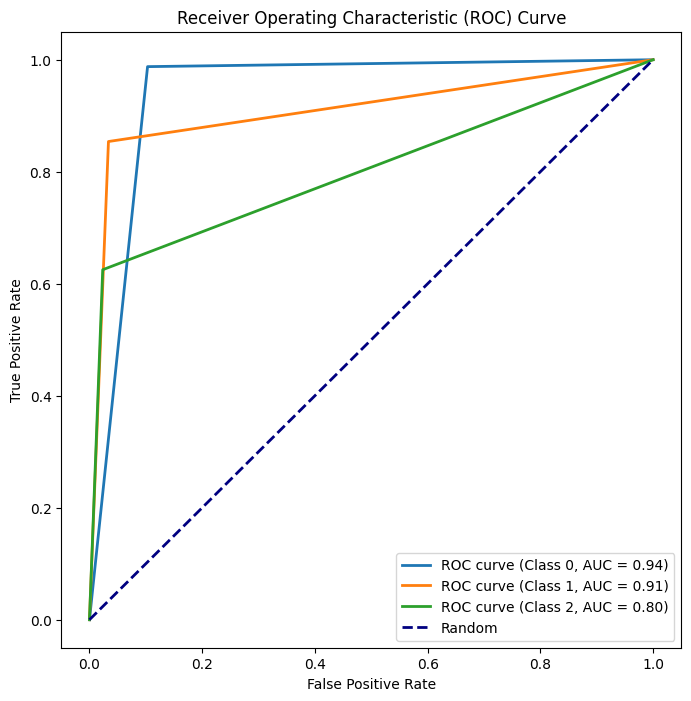

In [23]:
y_test_binary = label_binarize(y_test, classes=list(set(y_test)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(set(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], (y_pred == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(8, 8))
for i in range(len(set(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (Class {i}, AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


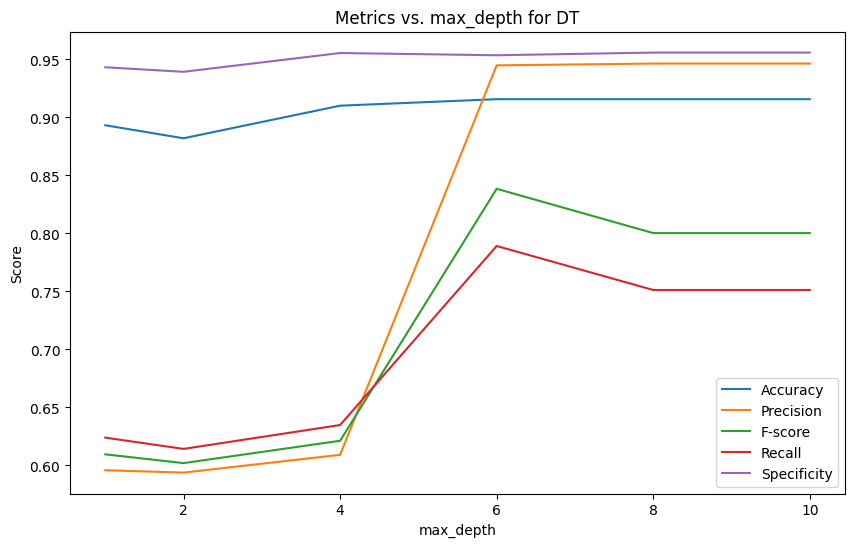

In [264]:
depths = [1, 2, 4, 6, 8, 10]
acc_scores = []
pre_scores = []
f_scores = []
rec_scores = []
spec_scores = []

for depth in depths:
    X = dataset.drop('Fertility', axis=1)
    feature_list = list(X.columns)
    tree = MyDecisionTreeClassifier( max_depth=depth)
    tree.fit(train_data[feature_list], train_data['Fertility'])
    # tree.print_tree()
    # Make predictions
    y_pred = tree.predict(test_data[feature_list])
    cm = utils.confusion_matrix(y_test, y_pred)
    
    acc = utils.accuracy(y_test, y_pred)
    pre = utils.precision(cm)
    f = utils.f_score(cm)
    rec = utils.recall(cm)
    spec = utils.specificity(cm)

    
    acc_scores.append(acc)
    pre_scores.append(pre)
    f_scores.append(f)
    rec_scores.append(rec)
    spec_scores.append(spec)


# Plotting
plt.figure(figsize=(10, 6))

plt.plot(depths, acc_scores, label='Accuracy')
plt.plot(depths, pre_scores, label='Precision')
plt.plot(depths, f_scores, label='F-score')
plt.plot(depths, rec_scores, label='Recall')
plt.plot(depths, spec_scores, label='Specificity')


plt.xlabel('max_depth')
plt.ylabel('Score')
plt.title('Metrics vs. max_depth for DT')
plt.legend()
plt.show()


# Compare the methodes

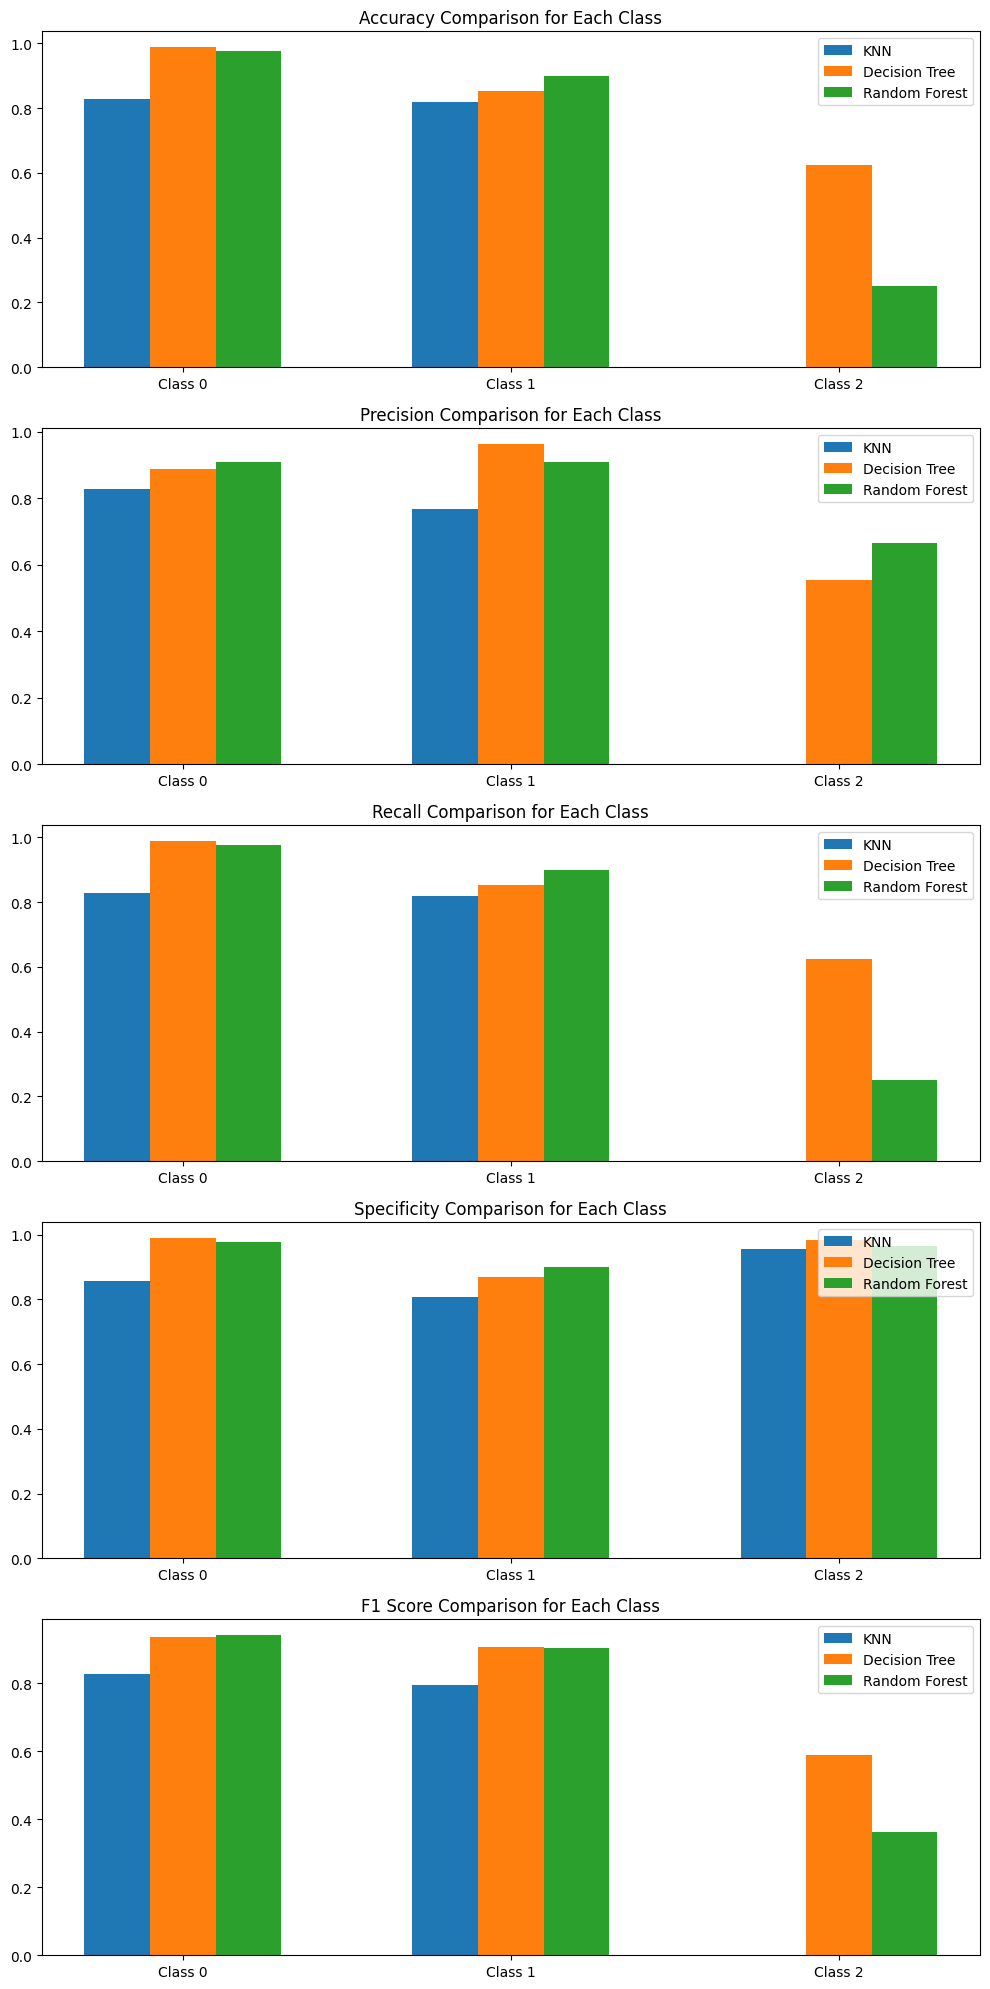

In [29]:
# Data for KNN
accuracy_knn = [accuracy0_knn, accuracy1_knn, accuracy2_knn]
precision_knn = [precision0_knn, precision1_knn, precision2_knn]
recall_knn = [recall0_knn, recall1_knn, recall2_knn]
specificity_knn = [specifity0_knn, specifity1_knn, specifity2_knn]
fscore_knn = [fscore0_knn, fscore1_knn, fscore2_knn]

# Data for Decision Tree (DT)
accuracy_dt = [accuracy0_dt, accuracy1_dt, accuracy2_dt]
precision_dt = [precision0_dt, precision1_dt, precision2_dt]
recall_dt = [recall0_dt, recall1_dt, recall2_dt]
specificity_dt = [specifity0_dt, specifity1_dt, specifity2_dt]
fscore_dt = [fscore0_dt, fscore1_dt, fscore2_dt]

# Data for Random Forest (RF)
accuracy_rf = [accuracy0_rf, accuracy1_rf, accuracy2_rf]
precision_rf = [precision0_rf, precision1_rf, precision2_rf]
recall_rf = [recall0_rf, recall1_rf, recall2_rf]
specificity_rf = [specifity0_rf, specifity1_rf, specifity2_rf]
fscore_rf = [fscore0_rf, fscore1_rf, fscore2_rf]

# Bar width
bar_width = 0.2
index = np.arange(len(accuracy_knn))

# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

# Plot accuracy
axs[0].bar(index - bar_width, accuracy_knn, bar_width, label='KNN')
axs[0].bar(index, accuracy_dt, bar_width, label='Decision Tree')
axs[0].bar(index + bar_width, accuracy_rf, bar_width, label='Random Forest')
axs[0].set_title('Accuracy Comparison for Each Class')
axs[0].set_xticks(index)
axs[0].set_xticklabels(['Class 0', 'Class 1', 'Class 2'])
axs[0].legend()

# Plot precision
axs[1].bar(index - bar_width, precision_knn, bar_width, label='KNN')
axs[1].bar(index, precision_dt, bar_width, label='Decision Tree')
axs[1].bar(index + bar_width, precision_rf, bar_width, label='Random Forest')
axs[1].set_title('Precision Comparison for Each Class')
axs[1].set_xticks(index)
axs[1].set_xticklabels(['Class 0', 'Class 1', 'Class 2'])
axs[1].legend()

# Plot recall
axs[2].bar(index - bar_width, recall_knn, bar_width, label='KNN')
axs[2].bar(index, recall_dt, bar_width, label='Decision Tree')
axs[2].bar(index + bar_width, recall_rf, bar_width, label='Random Forest')
axs[2].set_title('Recall Comparison for Each Class')
axs[2].set_xticks(index)
axs[2].set_xticklabels(['Class 0', 'Class 1', 'Class 2'])
axs[2].legend()

# Plot specificity
axs[3].bar(index - bar_width, specificity_knn, bar_width, label='KNN')
axs[3].bar(index, specificity_dt, bar_width, label='Decision Tree')
axs[3].bar(index + bar_width, specificity_rf, bar_width, label='Random Forest')
axs[3].set_title('Specificity Comparison for Each Class')
axs[3].set_xticks(index)
axs[3].set_xticklabels(['Class 0', 'Class 1', 'Class 2'])
axs[3].legend()

# Plot F1 score
axs[4].bar(index - bar_width, fscore_knn, bar_width, label='KNN')
axs[4].bar(index, fscore_dt, bar_width, label='Decision Tree')
axs[4].bar(index + bar_width, fscore_rf, bar_width, label='Random Forest')
axs[4].set_title('F1 Score Comparison for Each Class')
axs[4].set_xticks(index)
axs[4].set_xticklabels(['Class 0', 'Class 1', 'Class 2'])
axs[4].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


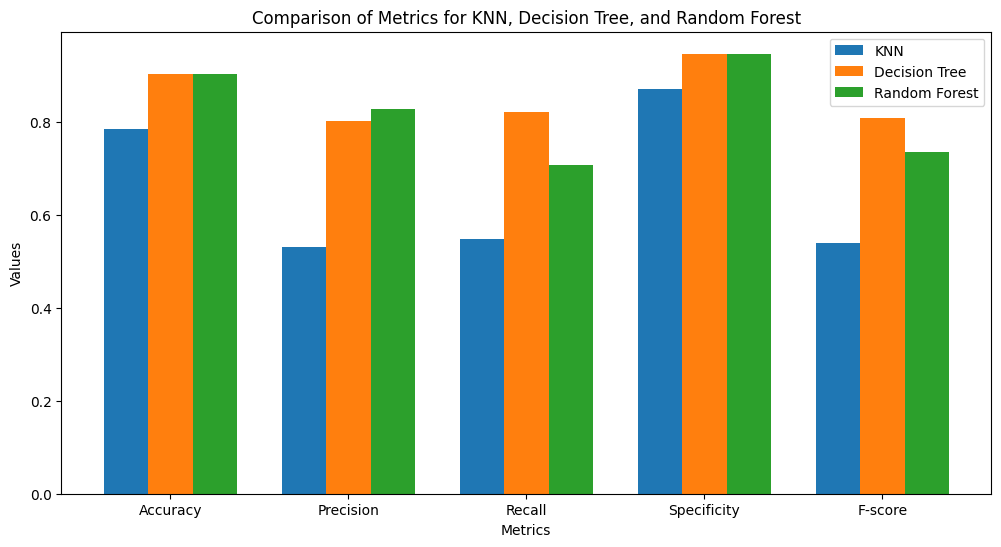

In [36]:
# Data for KNN
metrics_knn = [acc_knn, pre_knn, rec_knn, spec_knn, f1_knn]

# Data for Decision Tree (DT)
metrics_dt = [acc_dt, pre_dt, rec_dt, spec_dt, f1_dt]

# Data for Random Forest (RF)
metrics_rf = [acc_rf, pre_rf, rec_rf, spec_rf, f1_rf]

# Bar width
bar_width = 0.25
index = np.arange(len(metrics_knn))

# Create subplots
fig, ax = plt.subplots(figsize=(12, 6))

# Plot metrics for KNN
ax.bar(index - bar_width, metrics_knn, bar_width, label='KNN')
# Plot metrics for Decision Tree (DT)
ax.bar(index, metrics_dt, bar_width, label='Decision Tree')
# Plot metrics for Random Forest (RF)
ax.bar(index + bar_width, metrics_rf, bar_width, label='Random Forest')

# Customize the plot
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Metrics for KNN, Decision Tree, and Random Forest')
ax.set_xticks(index)
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'Specificity', 'F-score'])
ax.legend()

# Show the plot
plt.show()


# Let's try to fix the non balenced class destribution 

In [30]:
dataset = load_data('../Data/Dataset1_cleaned.csv')

In [31]:
X = dataset.drop('Fertility', axis=1)
Y = dataset['Fertility']

Using OverSampler

In [32]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Fit and transform the dataset
X_resampled, y_resampled = ros.fit_resample(X, Y)
X_resampled['Fertility']= y_resampled
dataset = X_resampled

In [33]:
# traiter chaque classe séparément
classe_0 = dataset[dataset['Fertility'] == 0]
print("Longueur de la classe 0 : ", len(classe_0))
classe_1 = dataset[dataset['Fertility'] == 1]
print("Longueur de la classe 1 : ", len(classe_1))
classe_2 = dataset[dataset['Fertility'] == 2]
print("Longueur de la classe 2 : ", len(classe_2))
# séparer les données en données d'apprentissage et de test
train_classe_0, test_classe_0 = train_test_split(classe_0, test_size=0.2)
train_classe_1, test_classe_1 = train_test_split(classe_1, test_size=0.2)
train_classe_2, test_classe_2 = train_test_split(classe_2, test_size=0.2)
# concaténer les données d'apprentissage et de test
train_data = pd.concat([train_classe_0, train_classe_1, train_classe_2], axis=0)
test_data = pd.concat([test_classe_0, test_classe_1, test_classe_2], axis=0)

Longueur de la classe 0 :  441
Longueur de la classe 1 :  441
Longueur de la classe 2 :  441


In [34]:
X_train = train_data.drop('Fertility', axis=1)
y_train = train_data['Fertility']
X_test = test_data.drop('Fertility', axis=1)
y_test = test_data['Fertility']
k =  3
knn_classifier = KNN(k=k)
# Appliquer le modèle sur les données d'apprentissage
knn_classifier.fit(X_train, y_train)
# Prédire les classes des données de test
y_pred = knn_classifier.predict(X_test)
print("Predicted labels:", y_pred)

Predicted labels: [1 0 0 1 0 1 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 1 0 2 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 2 0 0 1 1 0
 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 2 2 1 1 1 1 2 1
 1 0 1 1 2 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]


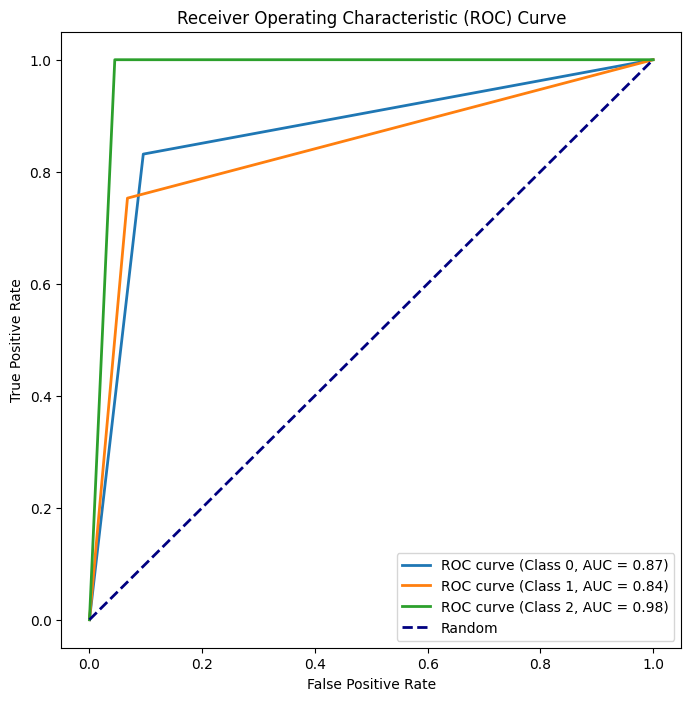

In [35]:
y_test_binary = label_binarize(y_test, classes=list(set(y_test)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(set(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], (y_pred == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(8, 8))
for i in range(len(set(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (Class {i}, AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [37]:
clf = RandomForestClassifier(n_estimators=25,
                                 max_depth=6,
                                 )
feature_list = list(X.columns)
# Entraîner le classificateur
clf.fit(train_data[feature_list], train_data['Fertility'])

y_pred = clf.predict(test_data[feature_list])
y_test = test_data['Fertility']


{split_feature:N,split_value:0.6304985337243402,left_tree:{split_feature:P,split_value:0.6886446886446889,left_tree:{split_feature:Fe,split_value:0.0119856172592888,left_tree:{split_feature:pH,split_value:0.6249999999999996,left_tree:{leaf_value:1},right_tree:{leaf_value:2}},right_tree:{split_feature:Zn,split_value:0.1605839416058394,left_tree:{split_feature:pH,split_value:0.5535714285714282,left_tree:{leaf_value:2},right_tree:{leaf_value:1}},right_tree:{split_feature:N,split_value:0.6129032258064516,left_tree:{leaf_value:0},right_tree:{split_feature:P,split_value:0.2857142857142857,left_tree:{leaf_value:0},right_tree:{leaf_value:1}}}}},right_tree:{split_feature:N,split_value:0.4486803519061583,left_tree:{leaf_value:0},right_tree:{leaf_value:1}}},right_tree:{split_feature:P,split_value:0.5421245421245423,left_tree:{split_feature:Fe,split_value:0.0415501398322013,left_tree:{split_feature:Mn,split_value:0.214025974025974,left_tree:{leaf_value:1},right_tree:{leaf_value:2}},right_tree:{spl

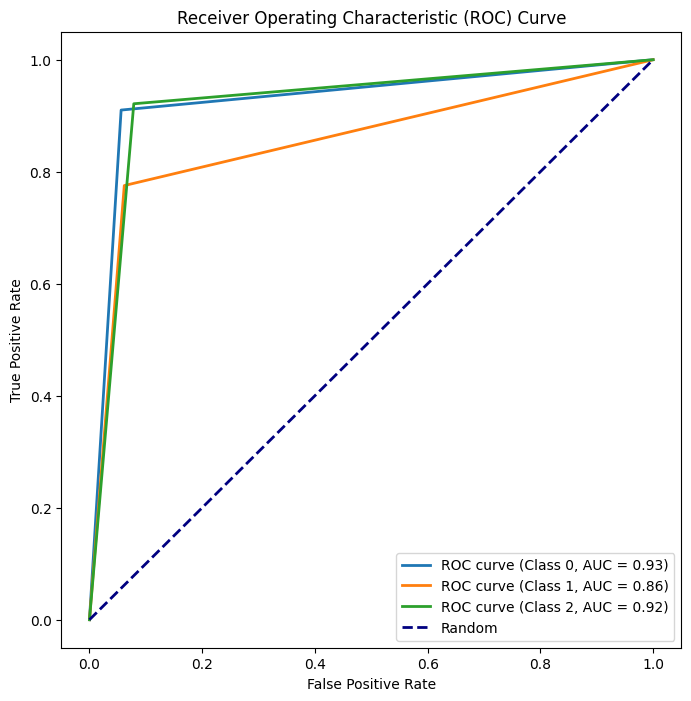

In [38]:
y_test_binary = label_binarize(y_test, classes=list(set(y_test)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(set(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], (y_pred == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(8, 8))
for i in range(len(set(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (Class {i}, AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [39]:
X = dataset.drop('Fertility', axis=1)
feature_list = list(X.columns)
tree = MyDecisionTreeClassifier(min_samples_split=2, max_depth=3, min_samples_leaf=1)
tree.fit(train_data[feature_list], train_data['Fertility'])
# tree.print_tree()
# Make predictions
y_pred = tree.predict(test_data[feature_list])
y_test = test_data['Fertility']
print(y_pred)

[1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 2 1 0 1 2 1
 1 0 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 0 2 1 1 1 1 1 1 1 0 1 1 1 1 2 2 2 1 1 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 0 1 1 1 1 1 1 2 1 2 0 2 2 2
 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 2]


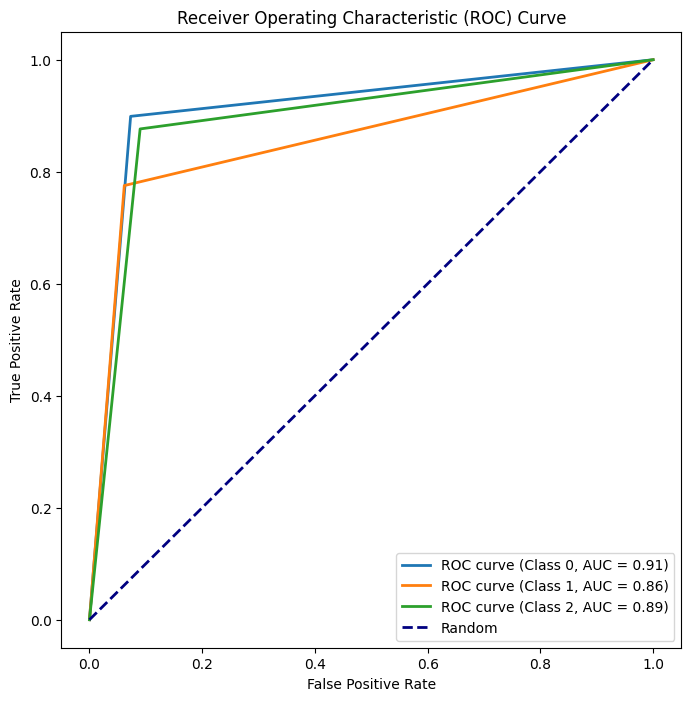

In [40]:
y_test_binary = label_binarize(y_test, classes=list(set(y_test)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(set(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], (y_pred == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(8, 8))
for i in range(len(set(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (Class {i}, AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Using SMOT

In [41]:
dataset = load_data('../Data/Dataset1_cleaned.csv')

In [42]:
X = dataset.drop('Fertility', axis=1)
Y = dataset['Fertility']

In [43]:
# traiter chaque classe séparément
classe_0 = dataset[dataset['Fertility'] == 0]
print("Longueur de la classe 0 : ", len(classe_0))
classe_1 = dataset[dataset['Fertility'] == 1]
print("Longueur de la classe 1 : ", len(classe_1))
classe_2 = dataset[dataset['Fertility'] == 2]
print("Longueur de la classe 2 : ", len(classe_2))
# séparer les données en données d'apprentissage et de test
train_classe_0, test_classe_0 = train_test_split(classe_0, test_size=0.2)
train_classe_1, test_classe_1 = train_test_split(classe_1, test_size=0.2)
train_classe_2, test_classe_2 = train_test_split(classe_2, test_size=0.2)
# concaténer les données d'apprentissage et de test
train_data = pd.concat([train_classe_0, train_classe_1, train_classe_2], axis=0)
test_data = pd.concat([test_classe_0, test_classe_1, test_classe_2], axis=0)

Longueur de la classe 0 :  401
Longueur de la classe 1 :  441
Longueur de la classe 2 :  40


In [48]:
X_train = train_data.drop('Fertility', axis=1)
y_train = train_data['Fertility']
X_test = test_data.drop('Fertility', axis=1)
y_test = test_data['Fertility']

In [49]:
from imblearn.over_sampling import SMOTE

smo = SMOTE(random_state=42)
X_sm, y_sm = smo.fit_resample(X_train, y_train)


In [52]:
k =  3
knn_classifier = KNN(k=k)
# Appliquer le modèle sur les données d'apprentissage
knn_classifier.fit(X_sm, y_sm)
# Prédire les classes des données de test
y_pred = knn_classifier.predict(X_test)
print("Predicted labels:", y_pred)

Predicted labels: [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 0 0 2 0 0 1 0 1 0 0 0 0 0 2 0 0 0 1
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 1 2 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 2 2 1 2 1 1 2
 1 0 1 1 1 0 1 1 0 2 0 1 1 1 0 2 2 2 1 1 1 2 2 2 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 0 1 0 1 1 0 1 1 1 1 2 2 2 1 1 1 0 1 0 1 2 2 1 2 2 2 1 1]


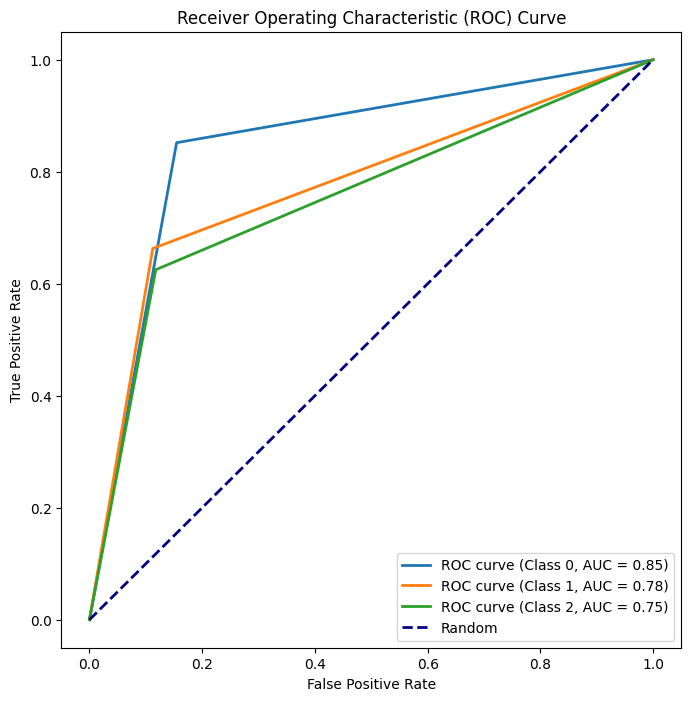

In [53]:
y_test_binary = label_binarize(y_test, classes=list(set(y_test)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(set(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], (y_pred == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(8, 8))
for i in range(len(set(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (Class {i}, AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [55]:

clf = RandomForestClassifier(n_estimators=25,
                                 max_depth=6,
                                 )

clf.fit(X_sm, y_sm)

y_pred = clf.predict(X_test)



{split_feature:N,split_value:0.6304985337243402,left_tree:{split_feature:P,split_value:0.5128205128205129,left_tree:{split_feature:B,split_value:0.7358490566037735,left_tree:{leaf_value:0},right_tree:{split_feature:pH,split_value:0.5535714285714282,left_tree:{split_feature:B,split_value:0.9506105763554614,left_tree:{leaf_value:2},right_tree:{split_feature:S,split_value:0.7444483609446598,left_tree:{leaf_value:0},right_tree:{leaf_value:0}}},right_tree:{split_feature:OC,split_value:0.5727296570019706,left_tree:{split_feature:Zn,split_value:0.5547445255474454,left_tree:{leaf_value:0},right_tree:{leaf_value:2}},right_tree:{leaf_value:1}}}},right_tree:{split_feature:pH,split_value:0.4374999999999998,left_tree:{split_feature:Fe,split_value:0.6719936076707949,left_tree:{split_feature:OC,split_value:0.609375,left_tree:{split_feature:N,split_value:0.32112334733794967,left_tree:{leaf_value:0},right_tree:{leaf_value:1}},right_tree:{leaf_value:2}},right_tree:{leaf_value:0}},right_tree:{leaf_value:

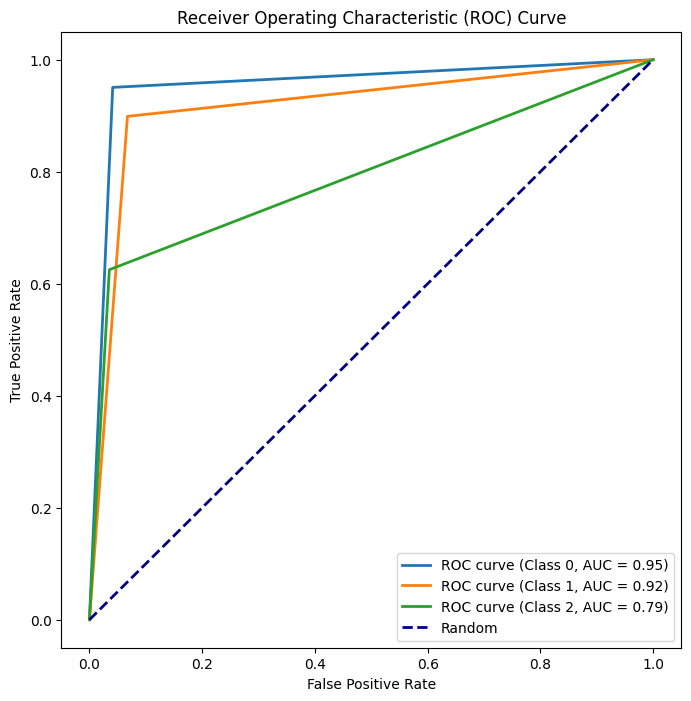

In [56]:
y_test_binary = label_binarize(y_test, classes=list(set(y_test)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(set(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], (y_pred == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(8, 8))
for i in range(len(set(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (Class {i}, AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [57]:
tree = MyDecisionTreeClassifier(min_samples_split=2, max_depth=3, min_samples_leaf=1)
tree.fit(X_sm, y_sm)
y_pred = tree.predict(X_test)

print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 2 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1
 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 2 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 1 2]


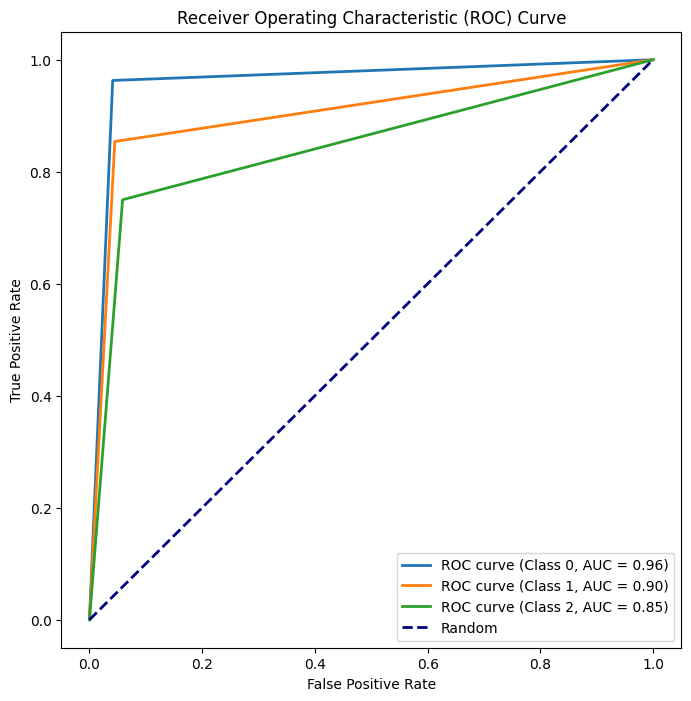

In [58]:
y_test_binary = label_binarize(y_test, classes=list(set(y_test)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(set(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], (y_pred == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(8, 8))
for i in range(len(set(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (Class {i}, AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()